In [1]:
import matplotlib.pyplot as plt
from time import time
from simfunctions import *

import matplotlib as mpl

# Take colors at regular intervals spanning the colormap.
colors = mpl.colormaps['Dark2'].colors

# SIS Model

$$ S + I \to I + I, c_1x_Sx_I $$
$$ S \to I, c_2x_S $$
$$ I \to S, c_3x_I $$
with parameters $c_1 = 0.008, c_2=0.1, c_3 = 0.3$


In [2]:
def rate1(X):
    rate = 0.016*X[0]*X[1]
    if rate > 0:
        return rate
    else:
        return 0

def rate2(X):
    rate = 0.1*X[0]
    if rate > 0:
        return rate
    else:
        return 0
    
def rate3(X):
    rate = 0.5*X[1]
    if rate > 0:
        return rate
    else:
        return 0
    
def jac(X):
    return np.array([[0.008*X[1], 0.008*X[0]], [0.1, 0], [0, 0.5]])

# Example usage:
drift = [rate1, rate2, rate3]
S_matrix = np.array([[-1, 1], [-1, 1], [1, -1]])  # Stoichiometry matrix
c = np.array([1,1,1])  # Reaction rates
X0 = np.array([90, 40])  # Initial state
T = 10  # Total time

## Tau-Leaping

In [3]:
def tau_leaping(drift, S, c, X0, T, tau):
    """
    drift: list of rate functions
    S: Stoichiometry matrix. Each row represents a reaction, and each column represents a species.
    c: Array of reaction rates.
    X0: Initial state.
    T: Total time.
    tau: Leap size.
    """
    steps = int(np.ceil(T/tau))
    K_list = []
    X = []
    t = []
    t0 = 0.
    X.append(X0)
    t.append(t0)
    
    for j in range(steps):
        a = c*np.array([rate(X[j]) for rate in drift])  # Propensity function
        K = np.random.poisson(a*tau)  # Number of reactions
        K_list.append(K)
        X_new = X[j] + np.dot(K, S)  # Update the state
        X.append(X_new)
        t.append(t[j]+tau)

        # Check for negative populations
        if np.any(X[j+1] < 0):
            print('Negative population, restarting run')
            return None, t
        
    return X, t, K_list

0.0 % simulations completed
10.0 % simulations completed
20.0 % simulations completed
30.0 % simulations completed
40.0 % simulations completed
50.0 % simulations completed
60.0 % simulations completed
70.0 % simulations completed
80.0 % simulations completed
90.0 % simulations completed
Number of steps:  35


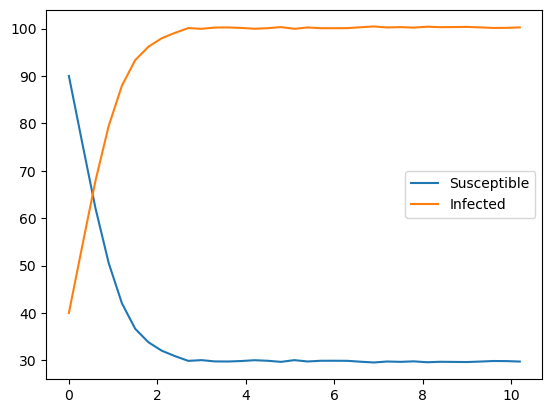

In [4]:
tau = 0.3  # Leap size

n_runs = 1000
runs = []
k_runs = []

for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_tau, K_list = tau_leaping(drift, S_matrix, c, X0, T, tau)
    runs.append(X)
    k_runs.append(K_list)
    
print('Number of steps: ', len(X))

Xs = np.mean(np.array(runs)[:,:,0], axis=0)
Xi = np.mean(np.array(runs)[:,:,1], axis=0)

plt.plot(t_tau, Xs, label='Susceptible')
plt.plot(t_tau, Xi, label='Infected')
plt.legend()

In [5]:
k_last = []

k1_list = []
k2_list = []
k1k2_list = []

for k_run in k_runs:
    k_last.append(k_run[-1])
    
for i in range(len(k_last)):
    k1 = k_last[0]
    k2 = k_last[1]
    k1_list.append(k1)
    k2_list.append(k2)
    k1k2_list.append(k1*k2)
    
np.mean(k1), np.mean(k2), np.mean(k1*k2)-np.mean(k1)*np.mean(k2)

(8.666666666666666, 9.333333333333334, 41.111111111111114)

## Mean-field

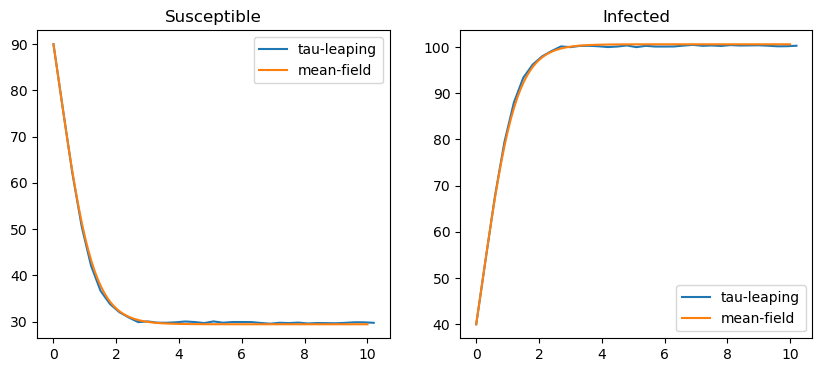

In [6]:
tmf = np.linspace(0,T, 100)
Xmf = mean_field(drift,S_matrix,c,X0,tmf)

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(t_tau, Xs, label='tau-leaping')
axs[0].plot(tmf, Xmf[:,0], label='mean-field')
axs[0].set_title('Susceptible')
axs[0].legend()

axs[1].plot(t_tau, Xi, label='tau-leaping')
axs[1].plot(tmf, Xmf[:,1], label='mean-field')
axs[1].set_title('Infected')
axs[1].legend()

## SOGA - Gaussian Approximation

In [7]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

compiledFile=compile2SOGA('../programs/SOGA/SSA/SIS.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist, dynams = start_SOGA(cfg)
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

returning 0 instead of 0.02264708500971019 mean 2.2766937850490194
returning 0 instead of 0.5661771252427445 mean 8.116531074754905
returning 0 instead of 0.04929837242932267 mean 1.8585844404777747
returning 0 instead of 1.2324593107330566 mean 10.207077797611126
returning 0 instead of 0.07778350720188451 mean 1.5030424444590456
returning 0 instead of 1.9445876800471023 mean 11.984787777704772
returning 0 instead of 0.10816197869552707 mean 1.2459200242399124
returning 0 instead of 2.7040494673881765 mean 13.27039987880044
returning 0 instead of 0.13961847727182167 mean 1.0889214813555332
returning 0 instead of 3.490461931795562 mean 14.055392593222335
returning 0 instead of 0.1677807445909622 mean 1.0113047098754075
returning 0 instead of 4.194518614774106 mean 14.443476450622963
returning 0 instead of 0.18979924298855116 mean 0.9829440916757958
returning 0 instead of 4.74498107471385 mean 14.585279541621023
returning 0 instead of 0.20604990215088806 mean 0.9784347731386969
returning

In [8]:
xs = np.array(dynams['xs'])
stds = np.sqrt(np.array(dynams['stds']))
xi = np.array(dynams['xi'])
stdi = np.sqrt(np.array(dynams['stdi']))

Text(0, 0.5, 'Number of individuals')

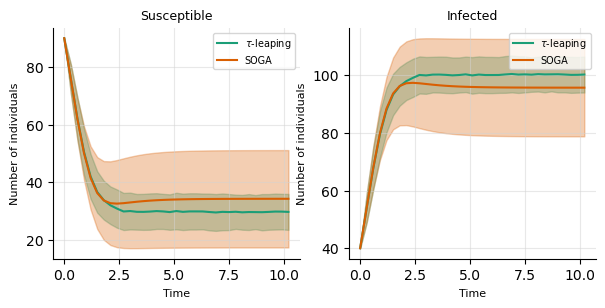

In [9]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

stdS = np.std(np.array(runs)[:,:,0], axis=0)
stdI = np.std(np.array(runs)[:,:,1], axis=0)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
#axs[0].plot(tmf, Xmf[:,0], label='mean-field', color='green')
axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].set_title('Susceptible', fontsize=9)
#axs[0].axhline(0)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(t_tau, Xi, label=r'$\tau$-leaping', color = colors[0])
axs[1].fill_between(t_tau, Xi-stdI, Xi+stdI, alpha=0.3, color=colors[0])
#axs[1].plot(tmf, Xmf[:,1], label='mean-field', color='green')
axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].set_title('Infected', fontsize=9)
#axs[1].axhline(0)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)

In [10]:
# with no correction

xs_nocorr = np.array([90.0, 75.88979283496731, 61.956098772205685, 50.10334985709105, 41.52759218942542, 36.303654214683334, 33.761585606733775, 32.87873362022764, 32.784673203659054, 32.98746639886619, 33.2661118903885, 33.53515868014799, 33.767479665945466, 33.9588081778363, 34.11287994578088, 34.23555881372553, 34.33266712837179, 34.409289650395515, 34.46963963094682, 34.51712300880245, 34.55445894165312, 34.583803924306764, 34.60686191602539, 34.624976418315654, 34.63920534759583, 34.65038104407957, 34.6591580130149, 34.66605072137445, 34.671463454703876, 34.67571384362567, 34.679051408324106, 34.6816721362253, 34.6837299556053, 34.68534575424788, 34.68661446715899])
stds_nocorr = np.array([0.0, 25.163427788566878, 55.29914774653298, 88.15366265591547, 123.87227928582183, 161.20293704033907, 194.50633508115197, 220.37070760867437, 239.41003236606593, 253.4567619411714, 264.01909110144607, 272.099858523311, 278.3537093056457, 283.2264336340654, 287.03712114433347, 290.02308551940746, 292.36518332820606, 294.203197035162, 295.6459918836672, 296.7786948474816, 297.66800795747895, 298.36625066944816, 298.91448247081576, 299.34493449991965, 299.6829108815225, 299.94827873980626, 300.1566367988428, 300.32023262940925, 300.4486825625354, 300.5495371197251, 300.62872466961176, 300.69090001299924, 300.7397179563227, 300.77804812667955, 300.80814364053435])

xs_corr_state = np.array([90.0, 75.88979283496731, 61.95282996709618, 50.100108724883974, 41.51567967966823, 36.3404950805564, 33.842241759805226, 32.97989561064569, 32.88520487527164, 33.0768358161026, 33.3412140416567, 33.596438228246086, 33.816690561149045, 33.99797896725279, 34.14390156083208, 34.26005334851956, 34.35197269420119, 34.42448797503892, 34.481595509489914, 34.52652339536121, 34.561847426836906, 34.58960962372453, 34.61142305196716, 34.62855929220625, 34.642019481651246, 34.652591203458606, 34.660893718807074, 34.667413762371176, 34.67253380407822, 34.676554329419794, 34.67971137908139, 34.682190353811, 34.68413686124378, 34.68566525427685, 34.68686533427793])
stds_corr_state = np.array([0.0, 25.163427788566878, 54.50087828907135, 86.10329878692892, 129.812311818941, 166.98710204711347, 199.56243516387826, 224.48112709346583, 242.65359475722198, 255.99585659796526, 266.00547235965496, 273.65545254559356, 279.5731887484744, 284.1830887311655, 287.7879076728484, 290.61244118436707, 292.8278745933012, 294.5664691096879, 295.9312157337738, 297.0026420739978, 297.84384406982304, 298.50431176753045, 299.022883798144, 299.43004783496053, 299.74973917020907, 300.0007501638322, 300.1978356507816, 300.3525805748932, 300.47408107823094, 300.56947915544947, 300.64438248795, 300.70319399828486, 300.7493707766255, 300.7856271928299, 300.81409447614146])

xs_corr_rate = np.array([90.0, 75.88979283496731, 61.95281468259249, 50.10141481530152, 41.53066747466375, 36.29738271185111, 33.710156995846916, 32.76480305585986, 32.614492437956564, 32.77350944941539, 33.018902706504335, 33.26214161957305, 33.47381180023414, 33.64821144561837, 33.788200156094106, 33.899081320410524, 33.986286755146935, 34.0546039326944, 34.108004315832716, 34.14968948977362, 34.18220286873129, 34.2075490774171, 34.227301045007785, 34.242689727944054, 34.25467690248104, 34.26401325002832, 34.27128428488621, 34.276946477553665, 34.281355574704385, 34.284788756565575, 34.28746194888013, 34.289543336645906, 34.29116390593636, 34.29242566328943, 34.29340804253471])
stds_corr_rate = np.array([0.0, 25.163427788566878, 54.77596936591408, 86.426119113205, 120.17997632836341, 155.13164141313518, 186.42304954551355, 210.88804776505685, 228.94433572320895, 242.23030494958948, 252.15955222630464, 259.6974658687466, 265.48304793256557, 269.9531957269364, 273.419862889034, 276.11368140928266, 278.20911117164883, 279.8399190903733, 281.1094428715892, 282.09783182014985, 282.86737782136333, 283.4665435818438, 283.9330513189668, 284.2962696256741, 284.57906543189597, 284.7992438180802, 284.97066848743975, 285.10413409678245, 285.20804552785853, 285.28894684537045, 285.3519332080293, 285.40097162180336, 285.439150702269, 285.468875156022, 285.4920172035763])

xs_corr = np.array([90.0, 75.88979283496731, 61.956098772205685, 50.10334985709105, 41.52759218942542, 36.303654214683334, 33.761585606733775, 32.87873362022764, 32.784673203659054, 32.98746639886619, 33.2661118903885, 33.53515868014799, 33.767479665945466, 33.9588081778363, 34.11287994578088, 34.23555881372553, 34.33266712837179, 34.409289650395515, 34.46963963094682, 34.51712300880245, 34.55445894165312, 34.583803924306764, 34.60686191602539, 34.624976418315654, 34.63920534759583, 34.65038104407957, 34.6591580130149, 34.66605072137445, 34.671463454703876, 34.67571384362567, 34.679051408324106, 34.6816721362253, 34.6837299556053, 34.68534575424788, 34.68661446715899])
stds_corr = np.array([0.0, 25.163427788566878, 55.29914774653298, 88.15366265591547, 123.87227928582183, 161.20293704033907, 194.50633508115197, 220.37070760867437, 239.41003236606593, 253.4567619411714, 264.01909110144607, 272.099858523311, 278.3537093056457, 283.2264336340654, 287.03712114433347, 290.02308551940746, 292.36518332820606, 294.203197035162, 295.6459918836672, 296.7786948474816, 297.66800795747895, 298.36625066944816, 298.91448247081576, 299.34493449991965, 299.6829108815225, 299.94827873980626, 300.1566367988428, 300.32023262940925, 300.4486825625354, 300.5495371197251, 300.62872466961176, 300.69090001299924, 300.7397179563227, 300.77804812667955, 300.80814364053435])

In [11]:
t = len(t_tau)

xs = np.zeros(t)
xi = np.zeros(t)
stds = np.zeros(t)
stdi = np.zeros(t)

for i in range(t):
    idxs = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi = output_dist.var_list.index('infected[{}]'.format(i))
    xs[i] = output_dist.gm.mean()[idxs]
    stds[i] = np.sqrt(output_dist.gm.cov()[idxs,idxs])
    xi[i] = output_dist.gm.mean()[idxi]
    stdi[i] = np.sqrt(output_dist.gm.cov()[idxi,idxi])

Text(0, 0.5, 'Number of individuals')

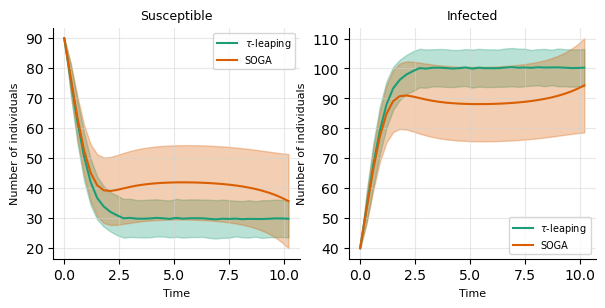

In [12]:
# conditioning on state

fig, axs = plt.subplots(1,2, figsize=(7,3))

stdS = np.std(np.array(runs)[:,:,0], axis=0)
stdI = np.std(np.array(runs)[:,:,1], axis=0)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
#axs[0].plot(tmf, Xmf[:,0], label='mean-field', color='green')
axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].set_title('Susceptible', fontsize=9)
#axs[0].axhline(0)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(t_tau, Xi, label=r'$\tau$-leaping', color = colors[0])
axs[1].fill_between(t_tau, Xi-stdI, Xi+stdI, alpha=0.3, color=colors[0])
#axs[1].plot(tmf, Xmf[:,1], label='mean-field', color='green')
axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].set_title('Infected', fontsize=9)
#axs[1].axhline(0)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)

# Chemical Langevin

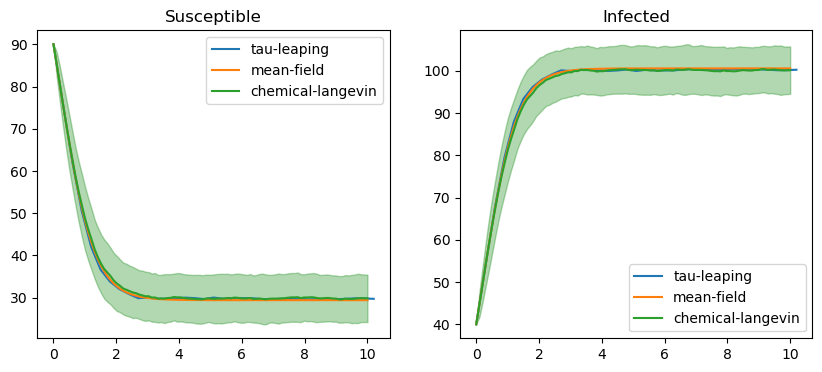

In [13]:
tcl = np.linspace(0,T, 10)
Xcl = []
for i in range(1000):
    Xcl.append(euler_maruyama(drift,S_matrix,c,X0,tmf))

Xcl_mean = np.mean(np.array(Xcl), axis=0)
std_xcl = np.std(np.array(Xcl), axis=0)

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(t_tau, Xs, label='tau-leaping')
axs[0].plot(tmf, Xmf[:,0], label='mean-field')
axs[0].plot(tmf, Xcl_mean[:,0], label='chemical-langevin')
axs[0].fill_between(tmf, Xcl_mean[:,0]-std_xcl[:,0], Xcl_mean[:,0]+std_xcl[:,0] ,alpha=0.3, color='green')
axs[0].set_title('Susceptible')
axs[0].legend()

axs[1].plot(t_tau, Xi, label='tau-leaping')
axs[1].plot(tmf, Xmf[:,1], label='mean-field')
axs[1].plot(tmf, Xcl_mean[:,1], label='chemical-langevin')
axs[1].fill_between(tmf, Xcl_mean[:,1]-std_xcl[:,1], Xcl_mean[:,1]+std_xcl[:,1] ,alpha=0.3, color='green')
axs[1].set_title('Infected')
axs[1].legend()

Text(0, 0.5, 'Number of individuals')

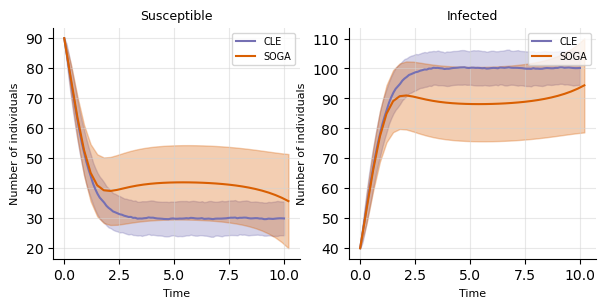

In [14]:
# Plot

fig, axs = plt.subplots(1,2, figsize=(7,3))

axs[0].plot(tmf, Xcl_mean[:,0], label='CLE', color=colors[2])
axs[0].fill_between(tmf, Xcl_mean[:,0]-std_xcl[:,0], Xcl_mean[:,0]+std_xcl[:,0] ,alpha=0.3,color=colors[2])
axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].set_title('Susceptible', fontsize=9)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(tmf, Xcl_mean[:,1], label='CLE', color=colors[2])
axs[1].fill_between(tmf, Xcl_mean[:,1]-std_xcl[:,1], Xcl_mean[:,1]+std_xcl[:,1] ,alpha=0.3, color=colors[2])
axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].set_title('Infected', fontsize=9)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)

## Linear Noise

In [ ]:
X, Sigma = linear_noise(drift,jac,S_matrix,c,X0,tmf)

In [ ]:
# Plot

fig, axs = plt.subplots(1,2, figsize=(7,3))

axs[0].plot(tmf, X[:,0], label='LNA', color=colors[7])
#axs[0].fill_between(tmf, X[:,0]-np.sqrt(Sigma[:,0,0]), X[:,0]+np.sqrt(Sigma[:,0,0]) ,alpha=0.3,color=colors[7])
axs[0].plot(tmf, X[:,0]-np.sqrt(Sigma[:,0,0])*1.96 ,'--',color=colors[7], linewidth=1)
axs[0].plot(tmf, X[:,0]+np.sqrt(Sigma[:,0,0])*1.96 ,'--',color=colors[7], linewidth=1)

axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
#axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].plot(t_tau, xs-stds*1.96 ,'--',color=colors[1], linewidth=1)
axs[0].plot(t_tau, xs+stds*1.96 ,'--',color=colors[1], linewidth=1)

axs[0].plot(tmf, Xcl_mean[:,0], label='CLE', color=colors[2])
#axs[0].fill_between(tmf, Xcl_mean[:,0]-std_xcl[:,0], Xcl_mean[:,0]+std_xcl[:,0] ,alpha=0.3,color=colors[2])
axs[0].plot(tmf, Xcl_mean[:,0]-std_xcl[:,0]*1.96 ,'--',color=colors[2], linewidth=1)
axs[0].plot(tmf, Xcl_mean[:,0]+std_xcl[:,0]*1.96 ,'--',color=colors[2], linewidth=1)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
#axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
axs[0].plot(t_tau, Xs-stdS*1.96 ,'--',color=colors[0], linewidth=1)
axs[0].plot(t_tau, Xs+stdS*1.96 ,'--',color=colors[0], linewidth=1)

axs[0].set_title('Susceptible', fontsize=9)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(tmf, X[:,1], label='LNA', color=colors[7])
#axs[1].fill_between(tmf, X[:,1]-np.sqrt(Sigma[:,1,1]), X[:,1]+np.sqrt(Sigma[:,1,1]) ,alpha=0.3,color=colors[7])
axs[1].plot(tmf, X[:,1]-np.sqrt(Sigma[:,1,1])*1.96 ,'--',color=colors[7], linewidth=1)
axs[1].plot(tmf, X[:,1]+np.sqrt(Sigma[:,1,1])*1.96 ,'--',color=colors[7], linewidth=1)

axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
#axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].plot(t_tau, xi-stdi*1.96 ,'--',color=colors[1], linewidth=1)
axs[1].plot(t_tau, xi+stdi*1.96 ,'--',color=colors[1], linewidth=1)

axs[1].plot(tmf, Xcl_mean[:,1], label='CLE', color=colors[2])
#axs[1].fill_between(tmf, Xcl_mean[:,1]-std_xcl[:,1], Xcl_mean[:,1]+std_xcl[:,1] ,alpha=0.3, color=colors[2])
axs[1].plot(tmf, Xcl_mean[:,1]-std_xcl[:,1]*1.96 ,'--',color=colors[2], linewidth=1)
axs[1].plot(tmf, Xcl_mean[:,1]+std_xcl[:,1]*1.96 ,'--',color=colors[2], linewidth=1)

axs[1].plot(t_tau, Xi, label=r'$\tau$-leaping', color = colors[0])
#axs[1].fill_between(t_tau, Xi-stdI, Xi+stdI, alpha=0.3, color=colors[0])
axs[1].plot(t_tau, Xi-stdI*1.96 ,'--',color=colors[0], linewidth=1)
axs[1].plot(t_tau, Xi+stdI*1.96 ,'--',color=colors[0], linewidth=1)

axs[1].set_title('Infected', fontsize=9)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)

plt.tight_layout()
plt.savefig('SI5mom1.png')

In [ ]:
tau = 0.3  # Leap size
T = 12
n_runs = 1000
runs = []

for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_tau = tau_leaping(drift, S_matrix, c, X0, T, tau)
    runs.append(X)
    
print('Number of steps: ', len(X))

Xs = np.mean(np.array(runs)[:,:,0], axis=0)
Xi = np.mean(np.array(runs)[:,:,1], axis=0)

stdS = np.std(np.array(runs)[:,:,0], axis=0)
stdI = np.std(np.array(runs)[:,:,1], axis=0)

In [ ]:
compiledFile=compile2SOGA('../programs/SOGA/SSA/SIS_longer.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg, pruning='ranking')
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

t = len(t_tau)

xs_l = np.zeros(t)
xi_l = np.zeros(t)
stds_l = np.zeros(t)
stdi_l = np.zeros(t)

for i in range(t):
    idxs_l = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi_l = output_dist.var_list.index('infected[{}]'.format(i))
    xs_l[i] = output_dist.gm.mean()[idxs_l]
    stds_l[i] = np.sqrt(output_dist.gm.cov()[idxs_l,idxs_l])
    xi_l[i] = output_dist.gm.mean()[idxi_l]
    stdi_l[i] = np.sqrt(output_dist.gm.cov()[idxi_l,idxi_l])

In [ ]:
compiledFile=compile2SOGA('../programs/SOGA/SSA/SIS_observe.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg, pruning='ranking')
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

t = len(t_tau)

xs_o = np.zeros(t)
xi_o = np.zeros(t)
stds_o = np.zeros(t)
stdi_o = np.zeros(t)

for i in range(t):
    idxs_o = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi_o = output_dist.var_list.index('infected[{}]'.format(i))
    xs_o[i] = output_dist.gm.mean()[idxs_o]
    stds_o[i] = np.sqrt(output_dist.gm.cov()[idxs_o,idxs_o])
    xi_o[i] = output_dist.gm.mean()[idxi_o]
    stdi_o[i] = np.sqrt(output_dist.gm.cov()[idxi_o,idxi_o])

In [ ]:
# Plot

fig, axs = plt.subplots(1,2, figsize=(7,3))

axs[0].plot(t_tau, xs_l, label='SOGA', color=colors[1])
#axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].plot(t_tau, xs_l-stds_l*1.96 ,'--',color=colors[1], linewidth=1)
axs[0].plot(t_tau, xs_l+stds_l*1.96 ,'--',color=colors[1], linewidth=1)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
#axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
axs[0].plot(t_tau, Xs-stdS*1.96 ,'--',color=colors[0], linewidth=1)
axs[0].plot(t_tau, Xs+stdS*1.96 ,'--',color=colors[0], linewidth=1)

axs[0].set_title('Susceptible without conditioning', fontsize=9)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(t_tau, xs_o, label='SOGA', color=colors[1])
#axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[1].plot(t_tau, xs_o-stds_o*1.96 ,'--',color=colors[1], linewidth=1)
axs[1].plot(t_tau, xs_o+stds_o*1.96 ,'--',color=colors[1], linewidth=1)

axs[1].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
#axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
axs[1].plot(t_tau, Xs-stdS*1.96 ,'--',color=colors[0], linewidth=1)
axs[1].plot(t_tau, Xs+stdS*1.96 ,'--',color=colors[0], linewidth=1)

axs[1].set_title('Susceptible with conditioning', fontsize=9)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)

plt.tight_layout()
plt.savefig('conditioning.png')

#FINO a 10 e comparare con TAU LEAPING

In [ ]:
output_dist.var_list.index('k3'), output_dist.var_list.index('susceptible[10]')

In [ ]:
output_dist.gm.cov()[30,12]